In [2]:
import os, json
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score

from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

from scipy import sparse
import os

RANDOM_STATE = 42

DATA_DIR = "data"
ART_DIR = "artifacts"
FIG_DIR  = os.path.join(ART_DIR, "figures")
LBL_DIR  = os.path.join(ART_DIR, "labels")

# Выбери любые 3 датасета (строго имена файлов из задания)
DATASETS = [
    "S07-hw-dataset-01.csv",
    "S07-hw-dataset-02.csv",
    "S07-hw-dataset-04.csv",
]

In [3]:
def basic_eda(df: pd.DataFrame, title: str = ""):
    print("="*100)
    print(title)
    display(df.head())
    print("\nINFO:")
    display(df.info())
    print("\nDESCRIBE (numeric):")
    display(df.select_dtypes(include=[np.number]).describe().T)
    print("\nMISSING VALUES:")
    na = df.isna().mean().sort_values(ascending=False)
    display(na[na > 0].to_frame("missing_share"))

def split_X_id(df: pd.DataFrame):
    assert "sample_id" in df.columns, "В датасете должна быть колонка sample_id"
    sample_id = df["sample_id"].copy()
    X = df.drop(columns=["sample_id"])
    return X, sample_id

def build_preprocessor(X: pd.DataFrame) -> ColumnTransformer:
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

    num_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ])

    # для категориальных: частые значения + OHE
    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
    ])

    pre = ColumnTransformer(
        transformers=[
            ("num", num_pipe, num_cols),
            ("cat", cat_pipe, cat_cols),
        ],
        remainder="drop",
        sparse_threshold=0.3
    )
    return pre

def to_dense(Xm):
    """Для PCA-2D. Синтетика обычно небольшая; если вдруг огромная — скажи, адаптируем."""
    if sparse.issparse(Xm):
        return Xm.toarray()
    return np.asarray(Xm)

def safe_internal_metrics(Xm, labels):
    """
    Возвращает dict метрик или NaN, если метрика не определена (например, 1 кластер).
    """
    out = {"silhouette": np.nan, "davies_bouldin": np.nan, "calinski_harabasz": np.nan}
    labs = np.asarray(labels)

    # нужно хотя бы 2 кластера (не считая шум, если он есть)
    uniq = set(labs.tolist())
    if len(uniq) < 2:
        return out

    try:
        out["silhouette"] = float(silhouette_score(Xm, labs))
    except Exception:
        pass
    try:
        out["davies_bouldin"] = float(davies_bouldin_score(Xm, labs))
    except Exception:
        pass
    try:
        out["calinski_harabasz"] = float(calinski_harabasz_score(Xm, labs))
    except Exception:
        pass
    return out

def safe_metrics_dbscan(Xm, labels):
    """
    Для DBSCAN считаем долю шума и метрики на non-noise (как требует задание — явно).
    """
    labs = np.asarray(labels)
    noise_frac = float(np.mean(labs == -1))
    mask = labs != -1
    out = {"noise_frac": noise_frac, "silhouette": np.nan, "davies_bouldin": np.nan, "calinski_harabasz": np.nan}

    # если после удаления шума меньше 2 кластеров — метрики не определены
    if mask.sum() < 3:
        return out
    uniq = set(labs[mask].tolist())
    if len(uniq) < 2:
        return out

    Xm_sub = Xm[mask]
    labs_sub = labs[mask]
    m = safe_internal_metrics(Xm_sub, labs_sub)
    out.update(m)
    return out

def plot_metric_curve(df_curve: pd.DataFrame, xcol: str, ycol: str, title: str, out_path: Path):
    plt.figure(figsize=(7,4))
    sns.lineplot(data=df_curve, x=xcol, y=ycol, marker="o")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.show()

def plot_pca_scatter(Xm, labels, title: str, out_path: str):
    Xd = Xm.toarray() if sparse.issparse(Xm) else np.asarray(Xm)
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    Z = pca.fit_transform(Xd)

    plt.figure(figsize=(6,5))
    sns.scatterplot(x=Z[:,0], y=Z[:,1], hue=labels, palette="tab10", s=25, linewidth=0, legend=False)
    plt.title(title + f"\nPCA explained var: {pca.explained_variance_ratio_.sum():.3f}")
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.show()

def save_labels_csv(sample_id: pd.Series, labels, out_path: str):
    pd.DataFrame({"sample_id": sample_id, "cluster_label": labels}).to_csv(out_path, index=False)

def dump_json(obj, path: str):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

In [4]:
K_RANGE = list(range(2, 21))

AGG_LINKAGES = ["ward", "average"]

DBSCAN_MIN_SAMPLES = [5, 10]



########################################################################################################################
DATASET 1: S07-hw-dataset-01
########################################################################################################################
EDA for S07-hw-dataset-01


,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
0,0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213



INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06        12000 non-null  float64
 7   f07        12000 non-null  float64
 8   f08        12000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB


None


DESCRIBE (numeric):


,count,mean,std,min,25%,50%,75%,max
sample_id,12000.0,5999.500000,3464.245950,0.000000,2999.750000,5999.500000,8999.250000,11999.000000
f01,12000.0,-2.424716,11.014315,-19.912573,-9.472623,-6.869404,0.523841,24.403381
f02,12000.0,19.107804,60.790338,-92.892652,-40.282955,54.069335,70.280739,112.229523
f03,12000.0,-0.222063,0.500630,-1.590979,-0.125145,-0.031753,0.054980,0.512277
f04,12000.0,-8.284501,59.269838,-134.303679,-48.345007,16.211728,28.067178,75.088604
f05,12000.0,-0.190717,7.026435,-11.869169,-5.132473,0.444730,3.942368,13.717091
f06,12000.0,0.962972,14.794713,-20.521164,-8.807706,-6.134169,2.334426,41.452857
f07,12000.0,0.033724,59.541782,-215.098834,-39.900520,-0.578494,39.719821,213.381767
f08,12000.0,0.007638,0.607053,-2.633469,-0.401483,0.005306,0.410132,2.490745



MISSING VALUES:


,missing_share


,model,k,silhouette,davies_bouldin,calinski_harabasz
0,kmeans,2,0.521640,0.685330,11786.954623
1,kmeans,3,0.396758,0.964604,10446.638111
2,kmeans,4,0.383301,1.160349,9427.499744
3,kmeans,5,0.354801,1.273719,8301.205994
4,kmeans,6,0.348097,1.150925,7479.989972
5,kmeans,7,0.324607,1.194162,6823.007844
13,kmeans,15,0.288351,1.040923,5729.707844
14,kmeans,16,0.282890,1.057868,5583.629062
15,kmeans,17,0.280149,1.048079,5495.578616
12,kmeans,14,0.278865,1.083090,5745.305458


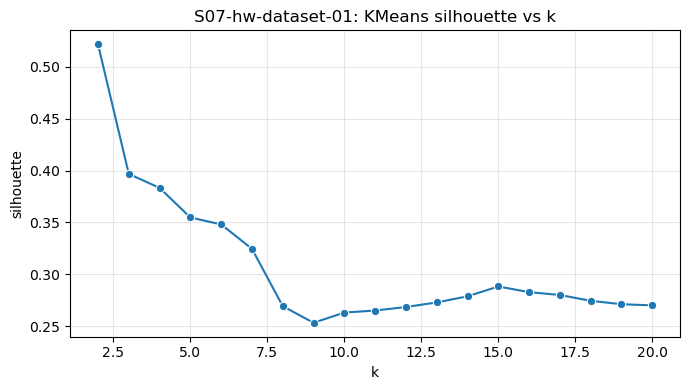

,model,linkage,k,silhouette,davies_bouldin,calinski_harabasz
0,agglomerative,ward,2,0.521640,0.685330,11786.954623
19,agglomerative,average,2,0.521640,0.685330,11786.954623
1,agglomerative,ward,3,0.396789,0.964410,10446.597694
2,agglomerative,ward,4,0.383180,1.160251,9425.768582
21,agglomerative,average,4,0.354791,1.113667,7049.365745
3,agglomerative,ward,5,0.345864,1.333936,8155.438530
4,agglomerative,ward,6,0.331647,1.224782,7189.672314
6,agglomerative,ward,8,0.329886,1.215727,6146.256531
20,agglomerative,average,3,0.318895,1.154435,5964.985360
5,agglomerative,ward,7,0.318726,1.240457,6557.751499


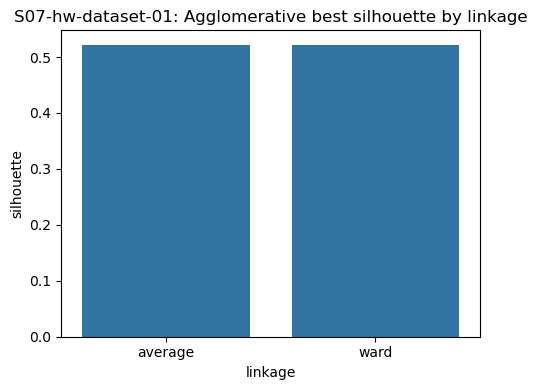

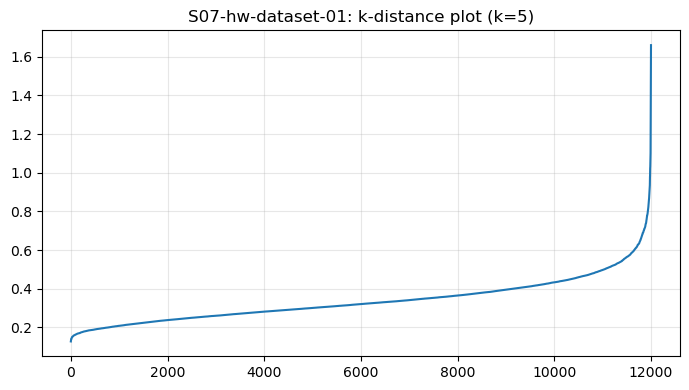

,model,eps,min_samples,noise_frac,silhouette,davies_bouldin,calinski_harabasz
6,dbscan,0.479675,10,0.080000,0.395385,1.183448,8646.072568
7,dbscan,0.513397,10,0.054250,0.391717,1.205264,8699.366360
9,dbscan,0.595394,10,0.020000,0.384769,1.238805,8571.100304
10,dbscan,0.638296,10,0.012667,0.382509,1.248305,8481.471602
4,dbscan,0.638296,5,0.007333,0.380694,1.256184,8401.982462
11,dbscan,0.720579,10,0.005417,0.380180,1.258466,8388.961581
5,dbscan,0.720579,5,0.003250,0.379345,1.262426,8342.296949
3,dbscan,0.595394,5,0.011417,0.329088,1.133821,6758.698088
8,dbscan,0.543744,10,0.037250,0.323016,1.140264,6964.064646
2,dbscan,0.543744,5,0.021333,0.294088,0.983144,4897.068049


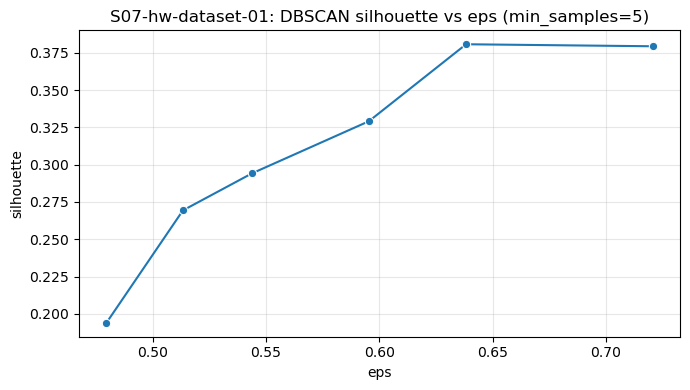

,model,silhouette
0,kmeans,0.521640
1,agglomerative,0.521640
2,dbscan,0.395385


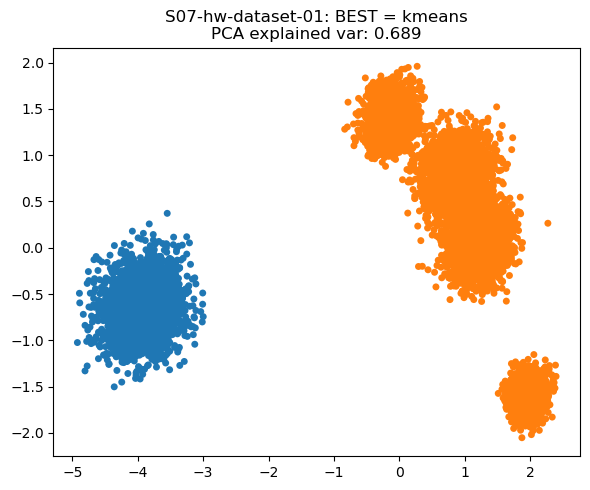


ИТОГ ПО ДАТАСЕТУ: S07-hw-dataset-01
Лучший метод: kmeans
Параметры: {'k': 2, 'random_state': 42, 'n_init': 20}
Метрики лучшего: {'silhouette': 0.5216395622404242, 'davies_bouldin': 0.6853295219054456, 'calinski_harabasz': 11786.954622671532}
DBSCAN noise_frac: 0.08


########################################################################################################################
DATASET 2: S07-hw-dataset-02
########################################################################################################################
EDA for S07-hw-dataset-02


,sample_id,x1,x2,z_noise
0,0,0.098849,-1.846034,21.288122
1,1,-1.024516,1.829616,6.072952
2,2,-1.094178,-0.158545,-18.938342
3,3,-1.612808,-1.565844,-11.629462
4,4,1.659901,-2.133292,1.895472



INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB


None


DESCRIBE (numeric):


,count,mean,std,min,25%,50%,75%,max
sample_id,8000.0,3999.500000,2309.545410,0.000000,1999.750000,3999.500000,5999.250000,7999.000000
x1,8000.0,0.478867,0.955138,-2.487352,-0.116516,0.490658,1.085263,2.987555
x2,8000.0,0.241112,0.663195,-2.499237,-0.242357,0.241092,0.726526,2.995553
z_noise,8000.0,0.110454,8.097716,-34.056074,-5.392210,0.132470,5.655605,29.460076



MISSING VALUES:


,missing_share


,model,k,silhouette,davies_bouldin,calinski_harabasz
0,kmeans,2,0.306861,1.323472,3573.393333
17,kmeans,19,0.286542,0.925527,2289.232513
14,kmeans,16,0.283854,0.955566,2329.437184
15,kmeans,17,0.282713,0.960999,2310.607765
18,kmeans,20,0.281387,0.935493,2268.515211
16,kmeans,18,0.278245,0.974203,2281.396021
13,kmeans,15,0.276016,0.966438,2300.267547
12,kmeans,14,0.271864,0.992412,2305.302085
1,kmeans,3,0.270084,1.225312,3082.774289
11,kmeans,13,0.266233,1.013180,2290.008792


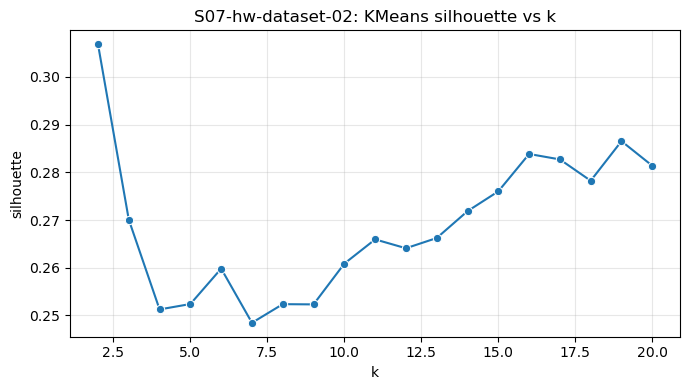

,model,linkage,k,silhouette,davies_bouldin,calinski_harabasz
19,agglomerative,average,2,0.419768,0.879129,395.482569
20,agglomerative,average,3,0.305097,0.977030,416.141543
21,agglomerative,average,4,0.304054,0.970822,454.970334
0,agglomerative,ward,2,0.265874,1.467368,2929.722348
22,agglomerative,average,5,0.253299,0.889067,346.432286
23,agglomerative,average,6,0.241628,0.913989,366.212685
24,agglomerative,average,7,0.225538,0.913238,307.349689
18,agglomerative,ward,20,0.222398,1.075692,1769.355297
17,agglomerative,ward,19,0.215709,1.058673,1789.366115
11,agglomerative,ward,13,0.209749,1.171583,1802.854972


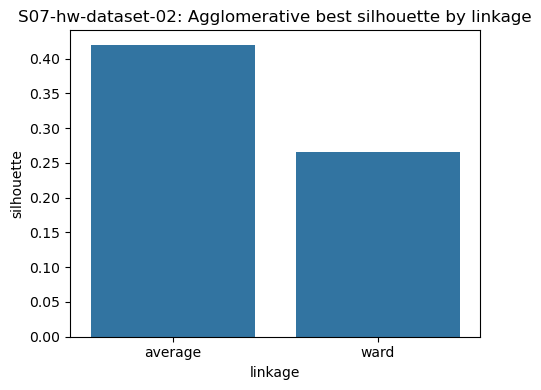

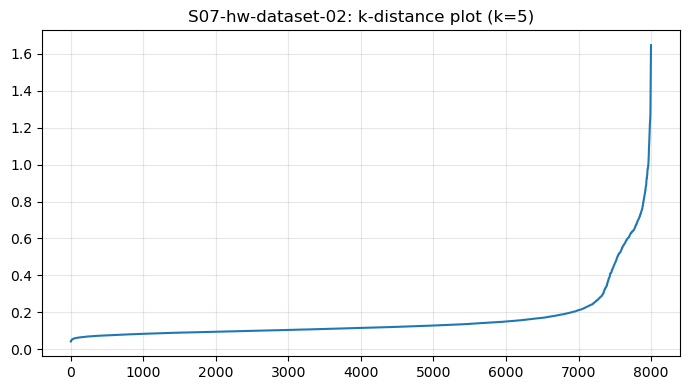

,model,eps,min_samples,noise_frac,silhouette,davies_bouldin,calinski_harabasz
10,dbscan,0.717130,10,0.032625,0.372642,0.545715,148.797013
9,dbscan,0.645810,10,0.048750,0.334705,0.641818,122.549597
3,dbscan,0.645810,5,0.015250,0.278682,0.672404,19.376460
6,dbscan,0.247301,10,0.103875,0.253948,1.509646,2799.493443
8,dbscan,0.545647,10,0.060250,0.246670,0.747886,28.341126
1,dbscan,0.410404,5,0.061500,0.136142,0.607765,32.773069
0,dbscan,0.247301,5,0.082250,0.028980,0.612142,16.793366
2,dbscan,0.545647,5,0.031250,-0.102451,0.841289,48.170345
4,dbscan,0.717130,5,0.009000,NaN,NaN,NaN
5,dbscan,0.857414,5,0.004375,NaN,NaN,NaN


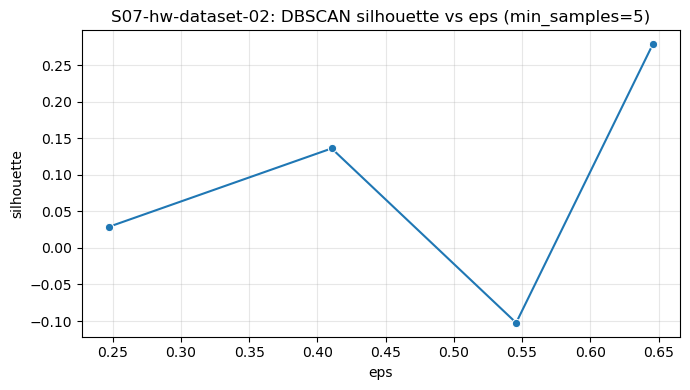

,model,silhouette
1,agglomerative,0.419768
2,dbscan,0.372642
0,kmeans,0.306861


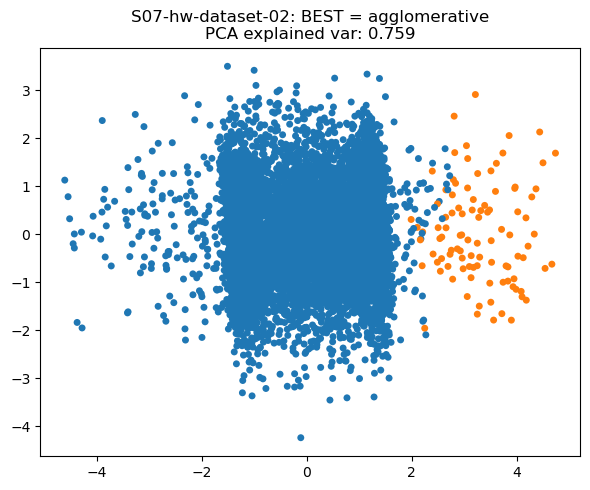


ИТОГ ПО ДАТАСЕТУ: S07-hw-dataset-02
Лучший метод: agglomerative
Параметры: {'k': 2, 'linkage': 'average'}
Метрики лучшего: {'silhouette': 0.41976775922231674, 'davies_bouldin': 0.8791287795996852, 'calinski_harabasz': 395.4825694831712}
DBSCAN noise_frac: 0.032625


########################################################################################################################
DATASET 3: S07-hw-dataset-04
########################################################################################################################
EDA for S07-hw-dataset-04


,sample_id,cat_a,cat_b,n01,n02,n03,n04,n05,n06,n07,...,n21,n22,n23,n24,n25,n26,n27,n28,n29,n30
0,0,B,X,-4.827501,-24.507466,-7.852963,0.771781,28.297884,-4.493911,-42.769449,...,24.597176,-26.354320,4.543397,-19.549036,-3.051332,-5.538587,-3.084457,5.499629,-6.128896,3.132067
1,1,F,V,51.302500,NaN,5.534737,51.305464,-8.027553,28.297548,NaN,...,-18.216260,8.527932,17.202115,-30.452260,0.855326,1.199066,3.597555,-2.239703,2.932710,0.473145
2,2,A,W,-4.820828,-2.625385,27.891578,1.523041,-5.776687,-16.298523,2.462937,...,-48.260775,9.313232,12.323411,55.081325,-3.945606,-0.280540,-0.130583,-7.353205,-2.942836,1.460477
3,3,B,X,-2.627573,-25.063639,-9.450011,-8.344669,22.371118,-11.525848,-43.762607,...,24.700663,-25.466915,-3.398665,-18.174541,0.438229,3.152556,3.859283,-2.678769,-2.213923,-4.724639
4,4,C,Y,-11.415710,-8.692169,48.636163,14.661826,-39.634618,10.769075,40.187536,...,-79.710383,-13.694253,41.575892,-9.498640,1.529608,-1.641347,3.500090,3.111257,1.475232,-1.321676



INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 33 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  10000 non-null  int64  
 1   cat_a      10000 non-null  object 
 2   cat_b      10000 non-null  object 
 3   n01        9826 non-null   float64
 4   n02        9811 non-null   float64
 5   n03        9801 non-null   float64
 6   n04        9808 non-null   float64
 7   n05        9799 non-null   float64
 8   n06        9817 non-null   float64
 9   n07        9796 non-null   float64
 10  n08        9806 non-null   float64
 11  n09        9805 non-null   float64
 12  n10        9811 non-null   float64
 13  n11        9796 non-null   float64
 14  n12        9798 non-null   float64
 15  n13        9803 non-null   float64
 16  n14        9802 non-null   float64
 17  n15        9814 non-null   float64
 18  n16        9809 non-null   float64
 19  n17        9788 non-null   float64
 20  

None


DESCRIBE (numeric):


,count,mean,std,min,25%,50%,75%,max
sample_id,10000.0,4999.500000,2886.895680,0.000000,2499.750000,4999.500000,7499.250000,9999.000000
n01,9826.0,17.348435,22.578551,-22.437090,-3.975438,22.042807,37.535647,65.446912
n02,9811.0,-2.057620,19.043410,-37.546998,-14.200552,-6.532183,2.092197,43.326647
n03,9801.0,7.908302,25.637807,-38.136412,-8.591513,0.350400,30.725630,60.185729
n04,9808.0,14.269157,18.815319,-23.374316,-1.223379,10.069142,29.807101,65.094588
n05,9799.0,0.900590,20.981294,-45.914070,-5.086756,2.413111,18.398883,42.527554
n06,9817.0,5.832787,13.221646,-20.650038,-4.532057,7.391953,13.033076,39.933274
n07,9796.0,-0.840875,26.583849,-60.297304,-13.554720,-2.429024,16.095731,48.591236
n08,9806.0,-4.888128,15.466271,-44.464550,-17.352641,-7.095546,3.909111,31.335431
n09,9805.0,3.184200,32.208740,-70.904880,-11.460490,13.258691,20.188426,64.696045



MISSING VALUES:


,missing_share
n26,0.0224
n21,0.0215
n18,0.0212
n17,0.0212
n28,0.0211
n24,0.0207
n07,0.0204
n11,0.0204
n20,0.0203
n29,0.0202


,model,k,silhouette,davies_bouldin,calinski_harabasz
3,kmeans,5,0.447369,0.975904,5087.688517
4,kmeans,6,0.423134,1.009677,5371.618125
5,kmeans,7,0.382855,1.655773,4567.399002
2,kmeans,4,0.374888,1.164396,3907.022658
6,kmeans,8,0.317996,2.104849,3990.988974
1,kmeans,3,0.294128,1.466640,3355.136730
7,kmeans,9,0.269358,2.460372,3559.693954
0,kmeans,2,0.255503,1.635731,3126.328083
8,kmeans,10,0.181547,2.788236,3223.850356
9,kmeans,11,0.141009,3.066447,2948.618481


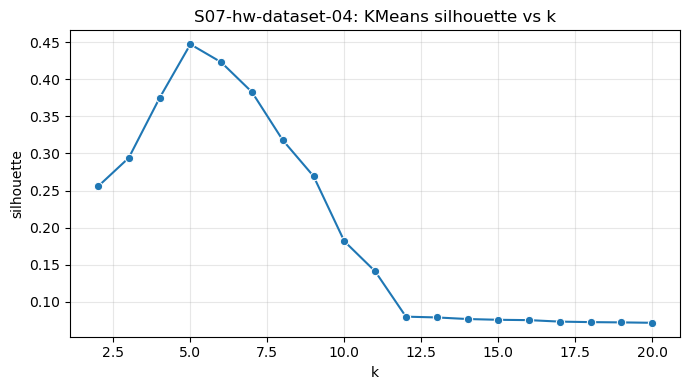

,model,linkage,k,silhouette,davies_bouldin,calinski_harabasz
3,agglomerative,ward,5,0.447369,0.975904,5087.688517
22,agglomerative,average,5,0.447369,0.975904,5087.688517
23,agglomerative,average,6,0.423797,0.900534,4071.625779
4,agglomerative,ward,6,0.423134,1.009677,5371.618125
24,agglomerative,average,7,0.409146,0.940288,4478.214099
25,agglomerative,average,8,0.400339,0.884459,3840.010757
2,agglomerative,ward,4,0.374888,1.164396,3907.022658
26,agglomerative,average,9,0.374608,0.981580,3361.659934
21,agglomerative,average,4,0.372104,1.119144,3739.606741
5,agglomerative,ward,7,0.364332,1.843482,4527.838998


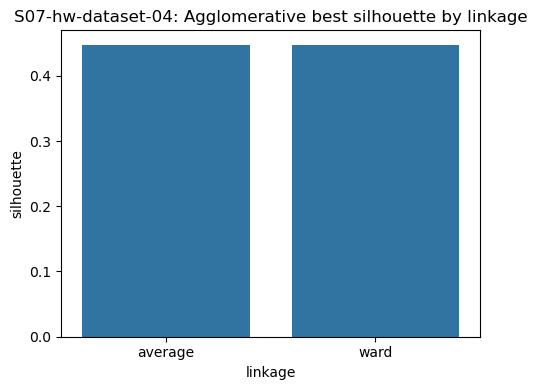

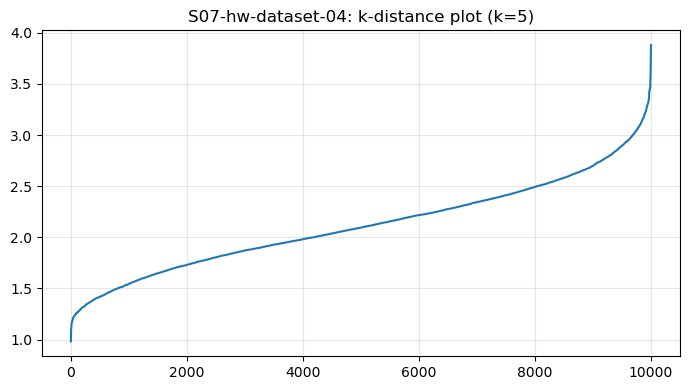

,model,eps,min_samples,noise_frac,silhouette,davies_bouldin,calinski_harabasz
10,dbscan,3.091648,10,0.0046,0.448437,0.973999,5094.692805
4,dbscan,3.091648,5,0.0042,0.448343,0.974181,5094.560437
11,dbscan,3.220878,10,0.0020,0.447842,0.975105,5092.037693
5,dbscan,3.220878,5,0.0017,0.447766,0.975223,5091.260590
6,dbscan,2.700148,10,0.0435,0.434114,0.987140,5402.300990
0,dbscan,2.700148,5,0.0399,0.433315,0.988727,5405.788854
7,dbscan,2.804325,10,0.0263,0.430074,0.995072,5406.644077
1,dbscan,2.804325,5,0.0243,0.429601,0.996192,5405.574681
8,dbscan,2.896426,10,0.0162,0.427521,1.000651,5400.043913
2,dbscan,2.896426,5,0.0150,0.427193,1.001260,5398.261066


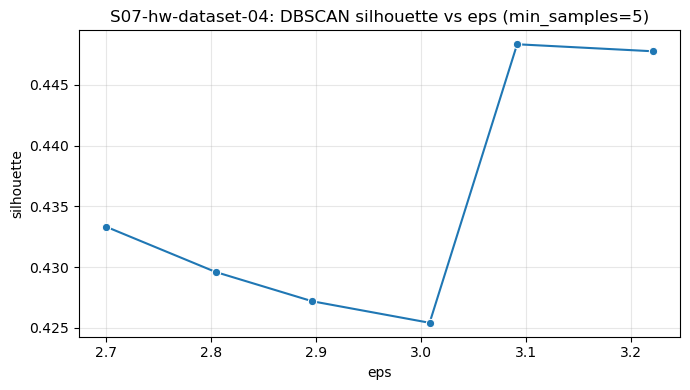

,model,silhouette
2,dbscan,0.448437
0,kmeans,0.447369
1,agglomerative,0.447369


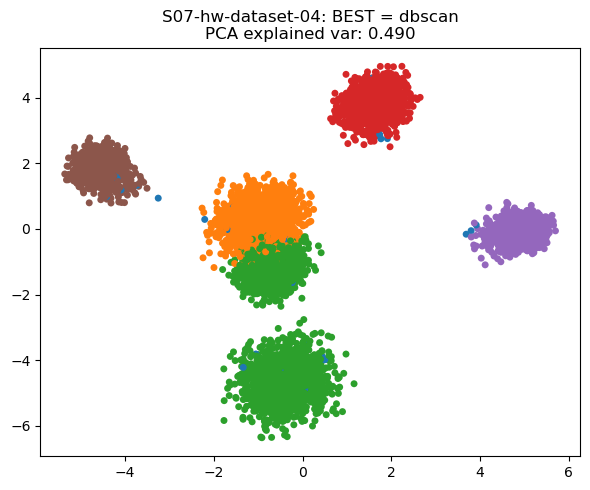


ИТОГ ПО ДАТАСЕТУ: S07-hw-dataset-04
Лучший метод: dbscan
Параметры: {'eps': 3.0916480544351073, 'min_samples': 10}
Метрики лучшего: {'noise_frac': 0.0046, 'silhouette': 0.44843658756120147, 'davies_bouldin': 0.9739988363747255, 'calinski_harabasz': 5094.692804593732}
DBSCAN noise_frac: 0.0046


In [5]:
metrics_summary = {}
best_configs = {}

for ds_idx, fname in enumerate(DATASETS, start=1):
    ds_name = fname.replace(".csv", "")
    print("\n\n" + "#"*120)
    print(f"DATASET {ds_idx}: {ds_name}")
    print("#"*120)

    path = os.path.join(DATA_DIR, fname)
    df = pd.read_csv(path)

    # 2.3.1 EDA
    basic_eda(df, title=f"EDA for {ds_name}")

    # split
    X, sample_id = split_X_id(df)

    # 2.3.2 Preprocessing (единый для всех моделей в датасете)
    pre = build_preprocessor(X)
    Xm = pre.fit_transform(X)  # матрица признаков после препроцессинга

    # Результаты по моделям здесь
    metrics_summary[ds_name] = {}

    # 2.3.3.1 KMeans подбор k
    kmeans_rows = []
    for k in K_RANGE:
        model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=20)
        labels = model.fit_predict(Xm)
        m = safe_internal_metrics(Xm, labels)
        kmeans_rows.append({"model": "kmeans", "k": k, **m})

    kmeans_df = pd.DataFrame(kmeans_rows)
    display(kmeans_df.sort_values("silhouette", ascending=False).head(10))

    # график silhouette vs k
    plot_metric_curve(
        kmeans_df, xcol="k", ycol="silhouette",
        title=f"{ds_name}: KMeans silhouette vs k",
        out_path=os.path.join(FIG_DIR, f"{ds_name}_kmeans_silhouette_vs_k.png") 
    )

    # выбираем лучший k по silhouette
    best_k_row = kmeans_df.iloc[kmeans_df["silhouette"].fillna(-1).argmax()]
    best_k = int(best_k_row["k"])

    best_kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=20)
    best_kmeans_labels = best_kmeans.fit_predict(Xm)
    metrics_summary[ds_name]["kmeans"] = {
        "params": {"k": best_k, "random_state": RANDOM_STATE, "n_init": 20},
        **safe_internal_metrics(Xm, best_kmeans_labels)
    }

    # 2.3.3.2 Agglomerative
    agg_rows = []
    Xm_agg = to_dense(Xm) if sparse.issparse(Xm) else Xm

    for linkage in AGG_LINKAGES:
        for k in K_RANGE:
            model = AgglomerativeClustering(n_clusters=k, linkage=linkage)
            labels = model.fit_predict(Xm_agg)
            m = safe_internal_metrics(Xm_agg, labels)
            agg_rows.append({"model": "agglomerative", "linkage": linkage, "k": k, **m})

    agg_df = pd.DataFrame(agg_rows)
    display(agg_df.sort_values("silhouette", ascending=False).head(10))

    # сравнение silhouette для разных linkage при лучшем k
    agg_best_by_linkage = agg_df.groupby("linkage", as_index=False)["silhouette"].max()
    plt.figure(figsize=(5,4))
    sns.barplot(data=agg_best_by_linkage, x="linkage", y="silhouette")
    plt.title(f"{ds_name}: Agglomerative best silhouette by linkage")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f"{ds_name}_agglo_best_silhouette_by_linkage.png"), dpi=150)
    plt.show()

    best_agg_row = agg_df.iloc[agg_df["silhouette"].fillna(-1).argmax()]
    best_agg_k = int(best_agg_row["k"])
    best_agg_linkage = str(best_agg_row["linkage"])

    best_agg = AgglomerativeClustering(n_clusters=best_agg_k, linkage=best_agg_linkage)
    best_agg_labels = best_agg.fit_predict(Xm_agg)
    metrics_summary[ds_name]["agglomerative"] = {
        "params": {"k": best_agg_k, "linkage": best_agg_linkage},
        **safe_internal_metrics(Xm_agg, best_agg_labels)
    }

    # DBSCAN
    dbscan_rows = []
    Xm_db = Xm

    # строим eps grid на основе квантилей расстояний
    min_s_for_grid = DBSCAN_MIN_SAMPLES[0]
    nn = NearestNeighbors(n_neighbors=min_s_for_grid)
    nn.fit(Xm_db)
    dists, _ = nn.kneighbors(Xm_db)
    kdist = np.sort(dists[:, -1])
    eps_candidates = np.unique(np.quantile(kdist, [0.90, 0.93, 0.95, 0.97, 0.98, 0.99]))
    eps_candidates = [float(e) for e in eps_candidates if e > 0]

    # k-distance plot
    plt.figure(figsize=(7,4))
    plt.plot(kdist)
    plt.title(f"{ds_name}: k-distance plot (k={min_s_for_grid})")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f"{ds_name}_dbscan_kdist.png"), dpi=150)  # <-- исправлено
    plt.show()

    for min_samples in DBSCAN_MIN_SAMPLES:
        for eps in eps_candidates:
            model = DBSCAN(eps=eps, min_samples=min_samples)
            labels = model.fit_predict(Xm_db)
            m = safe_metrics_dbscan(Xm_db, labels)
            dbscan_rows.append({"model": "dbscan", "eps": eps, "min_samples": min_samples, **m})

    dbscan_df = pd.DataFrame(dbscan_rows)
    display(dbscan_df.sort_values("silhouette", ascending=False).head(10))

    # silhouette vs eps для одного min_samples
    ms0 = DBSCAN_MIN_SAMPLES[0]
    df_plot = dbscan_df[dbscan_df["min_samples"] == ms0].sort_values("eps")
    plot_metric_curve(
        df_plot, xcol="eps", ycol="silhouette",
        title=f"{ds_name}: DBSCAN silhouette vs eps (min_samples={ms0})",
        out_path=os.path.join(FIG_DIR, f"{ds_name}_dbscan_silhouette_vs_eps_ms{ms0}.png")  # <-- исправлено
    )

    # лучший DBSCAN по silhouette
    if dbscan_df["silhouette"].notna().any():
        best_db_row = dbscan_df.iloc[dbscan_df["silhouette"].fillna(-1).argmax()]
        best_eps = float(best_db_row["eps"])
        best_min_samples = int(best_db_row["min_samples"])

        best_db = DBSCAN(eps=best_eps, min_samples=best_min_samples)
        best_db_labels = best_db.fit_predict(Xm_db)
        metrics_summary[ds_name]["dbscan"] = {
            "params": {"eps": best_eps, "min_samples": best_min_samples},
            **safe_metrics_dbscan(Xm_db, best_db_labels)
        }
    else:
        metrics_summary[ds_name]["dbscan"] = {
            "params": None,
            "noise_frac": np.nan,
            "silhouette": np.nan,
            "davies_bouldin": np.nan,
            "calinski_harabasz": np.nan
        }

    # 2.3.7 Выбор "лучшего" решения по датасету
    candidates = []
    for model_name, rec in metrics_summary[ds_name].items():
        candidates.append((model_name, rec.get("silhouette", np.nan)))
    candidates_df = pd.DataFrame(candidates, columns=["model", "silhouette"]).sort_values("silhouette", ascending=False)
    display(candidates_df)

    best_model_name = candidates_df.iloc[0]["model"]
    criterion = "max silhouette (внутр. метрика; для DBSCAN считалось на non-noise)"

    # Восстанавливаем labels для best модели
    if best_model_name == "kmeans":
        best_labels = best_kmeans_labels
        best_params = metrics_summary[ds_name]["kmeans"]["params"]
        Xm_vis = Xm
    elif best_model_name == "agglomerative":
        best_labels = best_agg_labels
        best_params = metrics_summary[ds_name]["agglomerative"]["params"]
        Xm_vis = Xm_agg
    else:
        # dbscan
        if metrics_summary[ds_name]["dbscan"]["params"] is not None:
            best_labels = best_db_labels
            best_params = metrics_summary[ds_name]["dbscan"]["params"]
        else:
            # fallback если DBSCAN невалиден
            best_model_name = "kmeans"
            best_labels = best_kmeans_labels
            best_params = metrics_summary[ds_name]["kmeans"]["params"]
        Xm_vis = Xm

    best_configs[ds_name] = {"best_model": best_model_name, "params": best_params, "criterion": criterion}

    # 2.3.5 PCA(2D) scatter для лучшего решения
    plot_pca_scatter(
        Xm_vis, best_labels,
        title=f"{ds_name}: BEST = {best_model_name}",
        out_path=os.path.join(FIG_DIR, f"{ds_name}_best_pca2d.png")  # <-- исправлено
    )

    # 2.4 Артефакты: labels csv
    out_lbl = os.path.join(LBL_DIR, f"labels_hw07_ds{ds_idx}.csv")  # <-- исправлено
    save_labels_csv(sample_id, best_labels, out_lbl)

    print("\nИТОГ ПО ДАТАСЕТУ:", ds_name)
    print("Лучший метод:", best_model_name)
    print("Параметры:", best_params)
    print("Метрики лучшего:", {k: v for k, v in metrics_summary[ds_name][best_model_name].items() if k != "params"})
    if "dbscan" in metrics_summary[ds_name]:
        print("DBSCAN noise_frac:", metrics_summary[ds_name]["dbscan"].get("noise_frac", None))

ИТОГ ПО ДАТАСЕТУ S07-hw-dataset-01:
1) В датасете только числовые признаки, пропусков нет, но шкалы сильно различаются (часть признаков ~десятки/сотни, часть ~доли).
2) Поэтому StandardScaler критичен: без масштабирования distance-based методы будут «смотреть» почти только на крупномасштабные признаки.
3) KMeans с k=2 дал лучшее качество: silhouette=0.522 (выше лучше), DB=0.685 (ниже лучше), CH=11787 (выше лучше).
4) Agglomerative (ward/average) фактически повторил результат KMeans, что ожидаемо при близкой «сферической» геометрии кластеров.
5) DBSCAN нашёл до ~8% шума и дал заметно более низкий silhouette (метрики считались на non-noise), что говорит о том, что разбиение по плотности здесь менее естественно.
6) Итог: выбираю KMeans(k=2), потому что кластеры хорошо отделимы в евклидовой геометрии после масштабирования и нет явной необходимости моделировать шум/нелинейность.

ИТОГ ПО ДАТАСЕТУ S07-hw-dataset-02:
1) Признаки x1/x2 имеют небольшие масштабы, дополнительно есть шумовой признак z_noise с большой дисперсией; пропусков нет.
2) Структура данных выглядит более сложной (нелинейность/выбросы), поэтому KMeans показывает относительно слабое качество (лучшее silhouette≈0.307).
3) Лучшее решение среди сравниваемых — Agglomerative с linkage='average', k=2: silhouette=0.420, DB=0.879.
4) Average-linkage менее «жёстко» предполагает шарообразные кластеры по сравнению с KMeans/ward и может лучше поддерживать более сложную форму кластеров.
5) DBSCAN дал неплохой silhouette≈0.373 (на non-noise) и выделил ~3.3% шума, но результат чувствителен к eps/min_samples и может быть менее стабилен.
6) Итог: выбираю Agglomerative(average, k=2) как компромисс: лучшее качество по silhouette при более простой настройке, чем у DBSCAN.

ИТОГ ПО ДАТАСЕТУ S07-hw-dataset-04:
1) Датасет высокоразмерный: 30 числовых + 2 категориальных признака; в числовых есть пропуски (~1.7–2.2% по колонкам).
2) Препроцессинг: median-impute для числовых + StandardScaler; категориальные кодируются OneHotEncoder, чтобы корректно использовать расстояния.
3) Среди методов лучший результат показал DBSCAN(eps≈3.092, min_samples=10): silhouette=0.448 (считали на non-noise), DB=0.974, CH≈5095.
4) Доля шума небольшая (~0.46%), что похоже на редкие выбросы/пограничные точки — DBSCAN аккуратно их отделяет.
5) KMeans/Agglomerative дают почти такой же silhouette (~0.447 при k=5), но требуют задавать k и не умеют явно выделять шум.
6) Итог: выбираю DBSCAN, потому что он не требует выбора k и лучше подходит, когда есть выбросы/шум и кластеры могут быть не идеально «шаровые».

,seed=0,seed=1,seed=2,seed=3,seed=4
seed=0,1.0,1.0,1.0,1.0,1.0
seed=1,1.0,1.0,1.0,1.0,1.0
seed=2,1.0,1.0,1.0,1.0,1.0
seed=3,1.0,1.0,1.0,1.0,1.0
seed=4,1.0,1.0,1.0,1.0,1.0


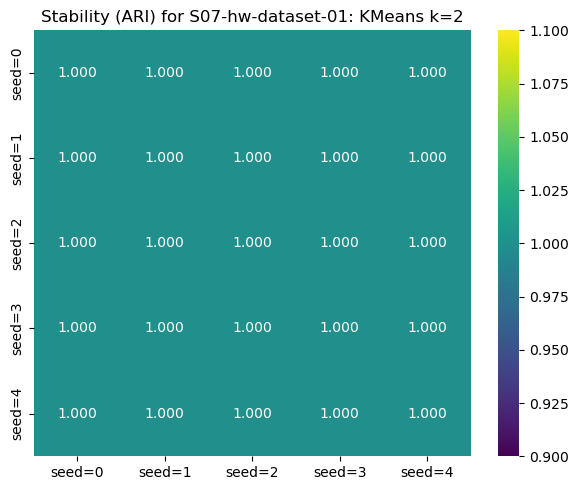

Mean off-diagonal ARI: 1.0


In [16]:
# Возьмём первый датасет из списка для устойчивости
STABILITY_FNAME = DATASETS[0]
st_name = STABILITY_FNAME.replace(".csv", "")

df = pd.read_csv(os.path.join(DATA_DIR, STABILITY_FNAME))
X, sample_id = split_X_id(df)
pre = build_preprocessor(X)
Xm = pre.fit_transform(X)

# Берем k из лучшего KMeans данного датасета
best_k = metrics_summary[st_name]["kmeans"]["params"]["k"]

seeds = [0, 1, 2, 3, 4]
labels_list = []

for s in seeds:
    km = KMeans(n_clusters=int(best_k), random_state=s, n_init=20)
    labels_list.append(km.fit_predict(Xm))

runs = len(seeds)
ari_mat = np.zeros((runs, runs))
for i in range(runs):
    for j in range(runs):
        ari_mat[i, j] = adjusted_rand_score(labels_list[i], labels_list[j])

ari_df = pd.DataFrame(ari_mat, index=[f"seed={s}" for s in seeds], columns=[f"seed={s}" for s in seeds])
display(ari_df)

plt.figure(figsize=(6,5))
sns.heatmap(ari_df, annot=True, fmt=".3f", cmap="viridis")
plt.title(f"Stability (ARI) for {st_name}: KMeans k={best_k}")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, f"{st_name}_kmeans_stability_ari.png"), dpi=150)
plt.show()

# Добавим в best_configs информацию про устойчивость
mean_offdiag = float((ari_mat.sum() - np.trace(ari_mat)) / (runs*(runs-1)))
best_configs[st_name]["stability"] = {
    "type": "KMeans 5 runs; metric=ARI",
    "k": int(best_k),
    "seeds": seeds,
    "ari_mean_offdiag": mean_offdiag
}

print("Mean off-diagonal ARI:", mean_offdiag)

In [18]:
dump_json(metrics_summary, os.path.join(ART_DIR, "metrics_summary.json"))
dump_json(best_configs, os.path.join(ART_DIR, "best_configs.json"))

print("Saved:")
print("-", os.path.join(ART_DIR, "metrics_summary.json"))
print("-", os.path.join(ART_DIR, "best_configs.json"))
print("-", "labels:", LBL_DIR)
print("-", "figures:", FIG_DIR)

Saved:
- artifacts\metrics_summary.json
- artifacts\best_configs.json
- labels: artifacts\labels
- figures: artifacts\figures
